<a href="https://colab.research.google.com/github/mrcasutt/lightinthedark/blob/master/light_the_dark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [49]:
#mount google drive to save models directly to drive
from google.colab import drive
drive.mount('/content/drive')
model_path = Path('/content/drive/My Drive/models/light')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#import libraries used
from fastai import *
from radam import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd
import numpy as np
import matplotlib as plt
from imutils import paths
from google.colab import files
import argparse
import requests
import cv2
import os
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFile
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

In [0]:
#command to delete training folder in case of mistake during download and initialization  
#shutil.rmtree('./train')

In [0]:
#set up paths and folders to download files
folder = 'full_size'
path = Path('./train')
dest = path/folder
fnpath = Path('./')
fnnames = './urls.csv'
dest.mkdir(parents=True, exist_ok=True)
classes = ['train']

In [0]:
#Javascript to add in browser console:
#urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
#window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [0]:
#fastai download tool using the urls generated by javascript above
download_images(fnpath/fnnames, dest, max_pics = 1000)

In [0]:
#fastai verify function to make sure images are readable
verify_images(dest, delete=True, max_size=2000)

In [0]:
#set up pathes used by resize and dataloader
path_orig = Path('./train/full_size')
path_hr = Path('./train/high_res')
path_mr = Path('./train/med_res')
path_lr = Path('./train/low_res')
il = ImageList.from_folder(path_orig)



In [0]:
#resize function
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_orig)                               #ceate destination path
    dest.parent.mkdir(parents=True, exist_ok=True)                      #create desination folder
    img = PIL.Image.open(fn)                                            #open image form path
    img = img.convert('RGB')                                            #force RGB for all images
    targ_sz = resize_to(img, size, use_min=True)                        #initialize target size
    enhancer = ImageEnhance.Brightness(img)                             #initialize brightness function
    b = random.uniform(0.2,0.4)                                         #random generator for brightness values
    img = enhancer.enhance(b)                                           #apply random brightness
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)              #resize image
    w,h = img.size                                                      #initialize width and height for save
    q = random.randint(10,70)                                           #random generator for quality
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255)) #draw the image object
    img.save(dest, quality=q)                                           #save image object in destination with random quality

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr,96),(path_mr,256),(path_hr,1200)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
#initialize batch size and size, model architecture and image names
bs,size = 32,96
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)


In [0]:
#function to get the data into a dataloader
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_orig/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
#load data
data = get_data(bs,size)

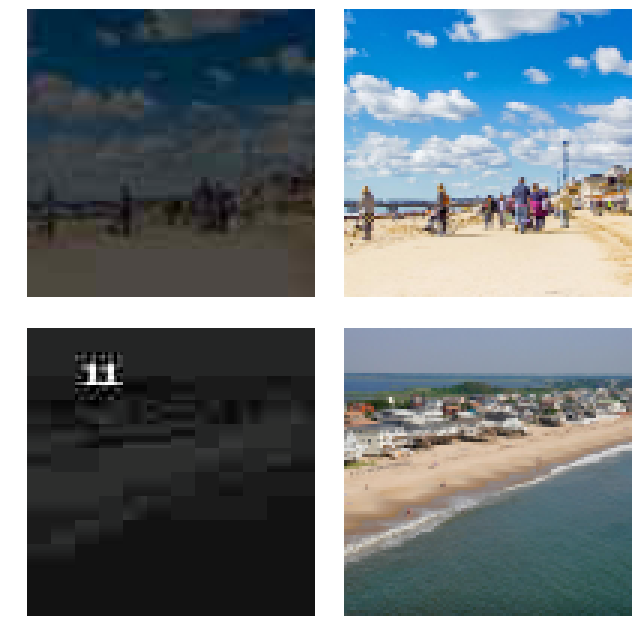

In [13]:
#show a couple of images 
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [14]:
#initialize vgg16 model (see fastai course v3/lesson 9 for details)
t = data.valid_ds[0][1].data
t = torch.stack([t,t])
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

gram_matrix(t)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:05<00:00, 101021846.75it/s]


([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [0]:
#create feature loss class for training
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [16]:
#set up learner object
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
raoptar = partial(RAdam) #RAadam used as optimizer
wd = 1e-3
lr = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight,opt_func=raoptar)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 120729552.88it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


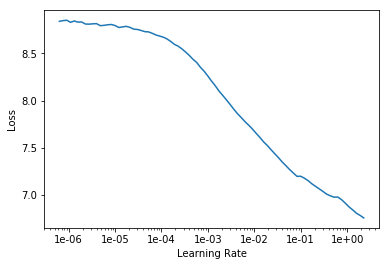

In [17]:
#find ideal learning rates
learn.lr_find()
learn.recorder.plot()

In [0]:
#create a do fit function that autosaves the result and displays some images after training
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycles=20):
    learn.fit_one_cycle(cycles, lrs, pct_start=pct_start)
    learn.save(model_path/save_name)
    learn.show_results(rows=3, imgsize=3)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,8.757014,7.481723,1.593487,0.392099,0.534947,0.237340,1.621679,2.668056,0.434116,00:35
1,8.495565,7.721029,1.589269,0.396389,0.557158,0.256439,1.578613,2.825304,0.517857,00:31
2,8.134718,7.559611,1.452677,0.394752,0.554855,0.256633,1.546807,2.830900,0.522987,00:31
3,7.756254,6.896604,1.243230,0.386362,0.535082,0.227398,1.460042,2.626443,0.418047,00:31
4,7.335405,6.359956,1.060876,0.385310,0.521309,0.195001,1.411324,2.457691,0.328445,00:31
5,6.970554,6.171578,0.984375,0.380197,0.519459,0.199778,1.356440,2.385772,0.345557,00:31
6,6.658199,5.882342,0.903466,0.372341,0.508104,0.190251,1.297160,2.282311,0.328708,00:31
7,6.381422,5.599768,0.818549,0.365239,0.498923,0.181980,1.234747,2.185769,0.314561,00:31
8,6.116927,5.345434,0.712506,0.359657,0.489084,0.176299,1.183976,2.114755,0.309159,00:31
9,5.861022,5.100399,0.607834,0.352664,0.480237,0.170968,1.130070,2.054169,0.304457,00:31


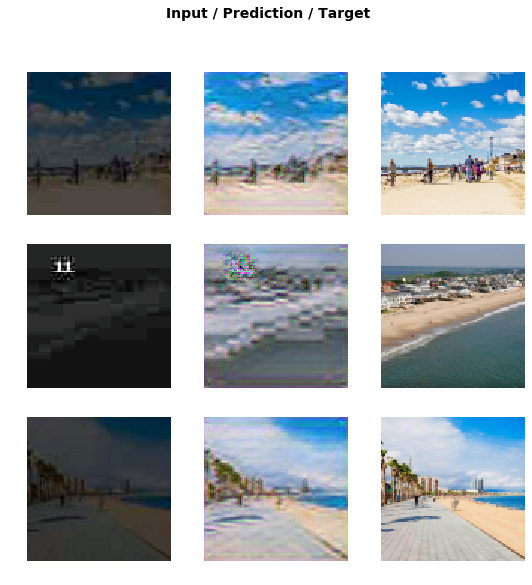

In [19]:
#first run training only the last layers on small images, autosave to train/models/1a
do_fit('1a', slice(1e-3,1e-1))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


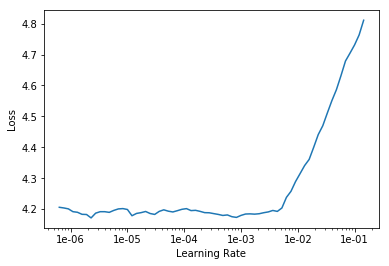

In [21]:
#unfreeze model and find new learning rates
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,4.226926,4.174044,0.427229,0.313793,0.409897,0.148505,0.855646,1.734643,0.284330,00:31
1,4.224621,4.173608,0.427232,0.313768,0.409814,0.148451,0.855494,1.734602,0.284247,00:31
2,4.212863,4.171648,0.426340,0.313688,0.409669,0.148425,0.855336,1.733968,0.284221,00:31
3,4.221872,4.171265,0.427871,0.313534,0.409429,0.148238,0.855212,1.732975,0.284006,00:32
4,4.223432,4.173568,0.428612,0.313747,0.409726,0.148439,0.855257,1.733520,0.284266,00:31
5,4.220083,4.167141,0.426971,0.313460,0.409084,0.148189,0.854333,1.731122,0.283983,00:32
6,4.227432,4.168639,0.426505,0.313672,0.409262,0.148241,0.854825,1.732129,0.284005,00:31
7,4.229960,4.171919,0.427898,0.313834,0.409762,0.148437,0.854698,1.733042,0.284248,00:32
8,4.225276,4.168776,0.426229,0.313852,0.409310,0.148419,0.854260,1.732403,0.284303,00:31
9,4.210801,4.172412,0.427502,0.314091,0.409788,0.148633,0.854238,1.733586,0.284575,00:31


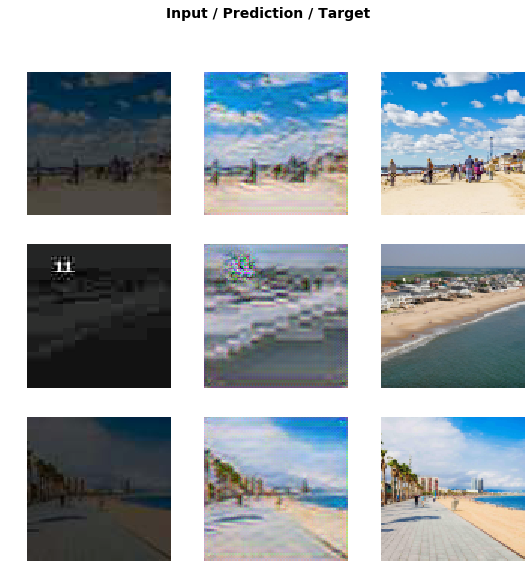

In [22]:
#second training run for whole model
do_fit('1b', slice(1e-6,1e-3))

In [0]:
#refreeze trained model
learn.freeze()

In [0]:
#initialize medium sized images as new dataset for training
size = 224
bs = 16
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_orig/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
#load medium sized images
learn.data = data_mr

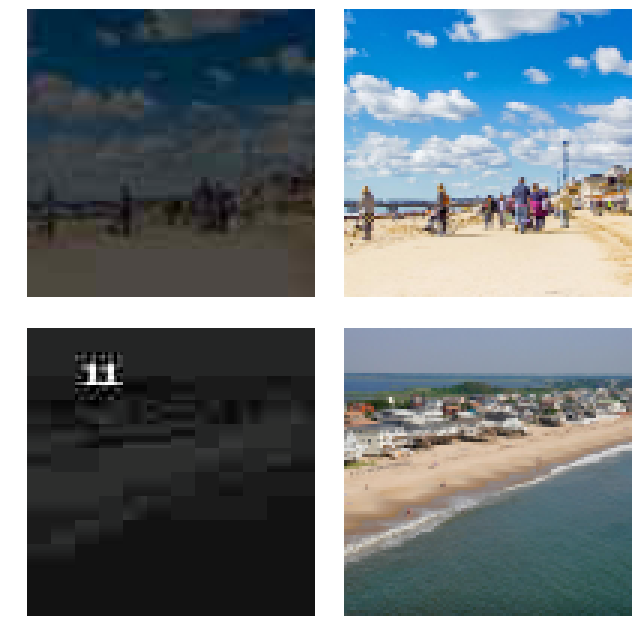

In [26]:
#show medium sized images
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [27]:
#free up some memory
gc.collect()

29042

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


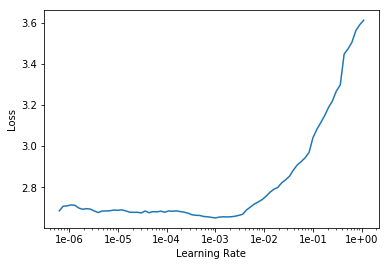

In [28]:
#find learning rates for last layers of larger images
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.681311,2.656915,0.407918,0.286097,0.313706,0.098127,0.566107,0.841681,0.143279,01:07
1,2.674204,2.657385,0.407061,0.286246,0.313886,0.098259,0.566438,0.842113,0.143381,01:01
2,2.677610,2.668034,0.409448,0.286735,0.314810,0.098497,0.568055,0.847082,0.143408,01:02
3,2.673456,2.662112,0.408141,0.286482,0.314043,0.098336,0.567406,0.844249,0.143455,01:00
4,2.677866,2.661279,0.408643,0.286473,0.314335,0.098413,0.567329,0.842578,0.143508,01:01
5,2.684201,2.669728,0.410409,0.286980,0.315143,0.098665,0.568143,0.846835,0.143553,01:01
6,2.678014,2.652281,0.407231,0.286158,0.313756,0.098109,0.565653,0.838142,0.143231,01:01
7,2.686762,2.650540,0.407789,0.286200,0.313743,0.098203,0.565171,0.836096,0.143339,01:01
8,2.684186,2.645907,0.406853,0.286102,0.313627,0.098176,0.564288,0.833534,0.143327,01:01
9,2.673656,2.643297,0.407184,0.286081,0.313775,0.098155,0.563775,0.831030,0.143297,01:02


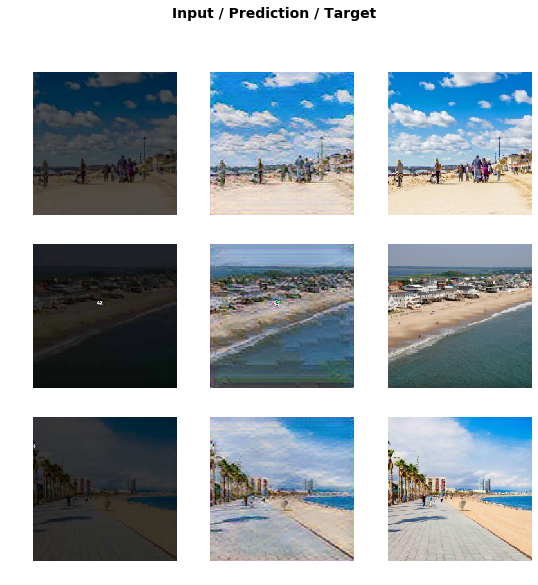

In [29]:
#train last layers of model on medium images
do_fit('2a',slice(1e-6,1e-3))

In [31]:
#unfreeze whole model and free up some memory
learn.unfreeze()
gc.collect()

21928

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


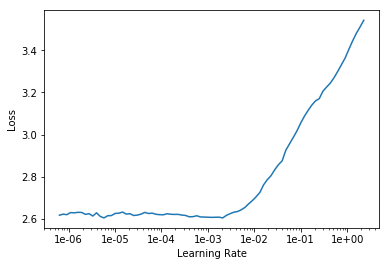

In [32]:
#find learning rates for whole model
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.638705,2.590204,0.402192,0.284282,0.311744,0.097156,0.553594,0.798433,0.142804,01:02
1,2.630295,2.600144,0.404197,0.284748,0.312392,0.097516,0.554916,0.803304,0.143071,01:02
2,2.621017,2.597861,0.405232,0.284639,0.312249,0.097532,0.554320,0.800750,0.143138,01:01
3,2.616108,2.594632,0.403403,0.284632,0.312026,0.097427,0.553850,0.800272,0.143021,01:02
4,2.619698,2.592160,0.404878,0.284357,0.311713,0.097401,0.553073,0.797622,0.143116,01:02
5,2.618683,2.585096,0.402483,0.284086,0.311566,0.097142,0.552142,0.794789,0.142886,01:02
6,2.617825,2.584803,0.401518,0.284145,0.311729,0.097188,0.552309,0.795069,0.142844,01:02
7,2.619469,2.586584,0.401505,0.284297,0.312153,0.097282,0.552010,0.796477,0.142860,01:01
8,2.619845,2.583766,0.403272,0.284141,0.311869,0.097279,0.551435,0.792743,0.143028,01:01
9,2.607886,2.580071,0.401089,0.284047,0.311780,0.097175,0.550715,0.792367,0.142897,01:02


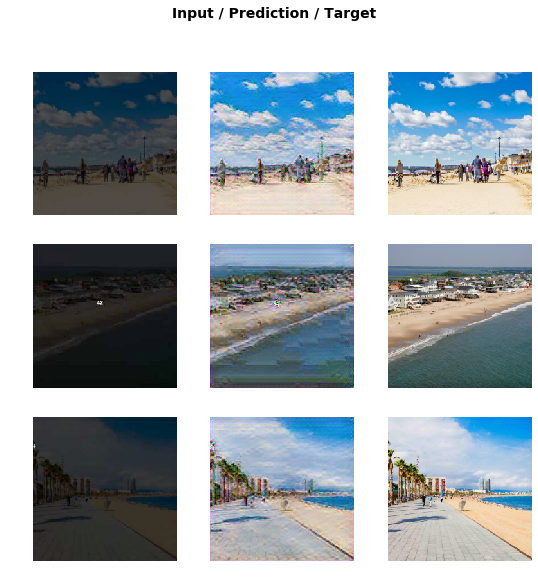

In [33]:
#fit whole model with medium sized images
do_fit('2b', slice(1e-5 ), pct_start=0.3)

In [34]:
#destroy learner
learn.destroy()


this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
#make sure learner is empty
learn = None

In [36]:
#free up cuda memory
torch.cuda.empty_cache()
gc.collect()

9

In [0]:
#recreate learner object 
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight,opt_func=raoptar)

In [38]:
#load model that was trained on medium sized images
learn.load('2b')

Learner(data=ImageDataBunch;

Train: LabelList (488 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: train/low_res;

Valid: LabelList (54 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: train/low_res;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64,

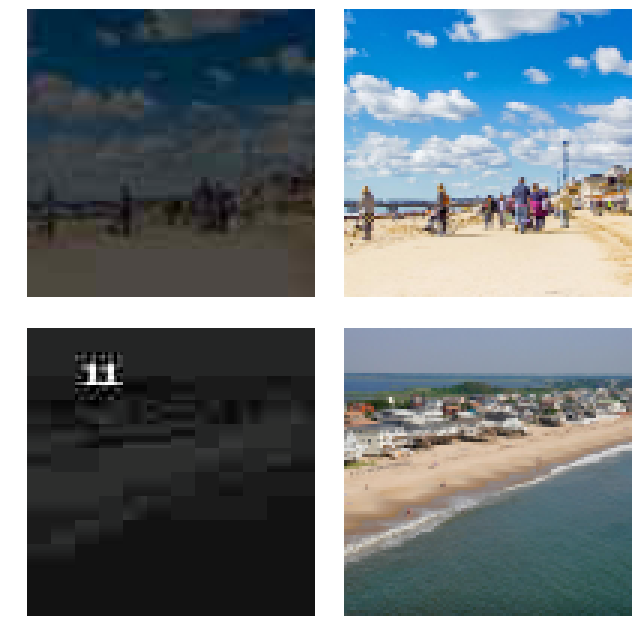

In [39]:
#initialize high res images and show some
size = 800
bs=1
data_hr = (ImageImageList.from_folder(path_hr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_orig/x.name)
          .transform(get_transforms(max_zoom=2),size = size, tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data_hr.c = 3
learn.data = data_hr
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [40]:
#empty memory
torch.cuda.empty_cache()
gc.collect()

7046

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


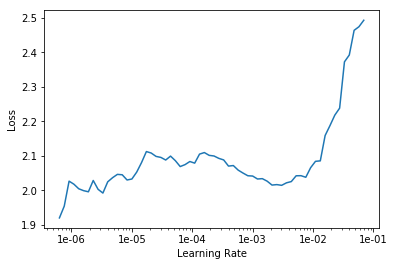

In [41]:
#find learning rates for last layer of high res data
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.676753,1.705644,0.475964,0.231268,0.228248,0.047187,0.381441,0.307099,0.034436,17:31
1,1.663218,1.771491,0.518035,0.232848,0.229374,0.048738,0.395070,0.313495,0.033932,17:27
2,1.605360,1.709118,0.434381,0.218109,0.220484,0.048372,0.436919,0.317519,0.033333,17:28
3,1.961719,1.577803,0.477524,0.204593,0.203210,0.040899,0.351715,0.268955,0.030906,17:14
4,1.590502,1.441229,0.407320,0.203441,0.197764,0.040002,0.333859,0.229340,0.029503,17:05
5,1.526633,1.375471,0.376053,0.201789,0.194876,0.039029,0.315986,0.219206,0.028532,17:04


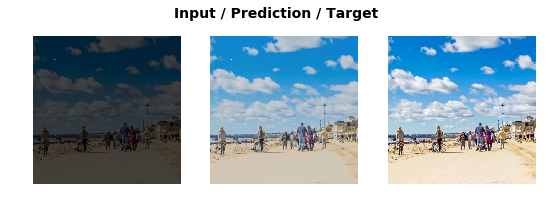

In [48]:
do_fit('3a',slice(8e-3,1e-3),cycles=6)

In [0]:
learn.save(model_path/'light_model')

In [0]:
#unfreeze model
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


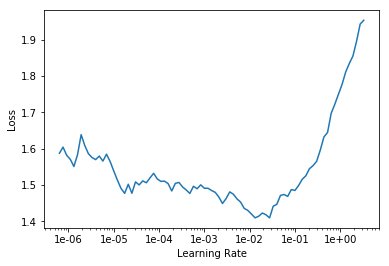

In [53]:
#find learning rates
learn.lr_find()
learn.recorder.plot()

In [0]:
#fit whole model on high res data
do_fit('light_model_full',slice(1e-4,1e-2),cycles=8)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.487290,1.372970,0.373824,0.201826,0.194915,0.039032,0.315619,0.219250,0.028506,17:34
1,1.486619,1.363907,0.364275,0.202083,0.195145,0.039078,0.314810,0.220075,0.028442,17:35
2,1.464639,1.357889,0.357694,0.202370,0.195202,0.039111,0.314737,0.220401,0.028374,17:34


In [0]:
#destroy learner object
learn.destroy()

In [0]:
#make sure learner is empty and free up as much memeory as possible
learn = None
torch.cuda.empty_cache()
gc.collect()

In [0]:
#recreate new learner
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight,opt_func=raoptar)

In [0]:
#load model trained on high res data
learn.load(model_path/'light_model_full');

In [0]:
#initialize highest res images and show some
size = 1200
bs=1
data_hr = (ImageImageList.from_folder(path_hr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_orig/x.name)
          .transform(get_transforms(max_zoom=2),size = size, tfm_y=True)
          .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data_hr.c = 3
learn.data = data_hr
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [0]:
#load highest res data
learn.data = data_hr

In [0]:
#try to free some memory
torch.cuda.empty_cache()

In [0]:
gc.collect()

122

In [0]:
#find learning rate
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

epoch,train_loss,valid_loss,time
0,0.374939,0.210284,12:59
1,0.108875,0.113063,12:40
2,0.065830,0.066140,12:38
3,0.051884,0.080506,12:37
4,0.049547,0.057463,12:35
5,0.043214,0.044299,12:34
6,0.047292,0.048972,12:35
7,0.043585,0.051908,12:33
8,0.043586,0.033640,12:33
9,0.014837,0.014612,12:33


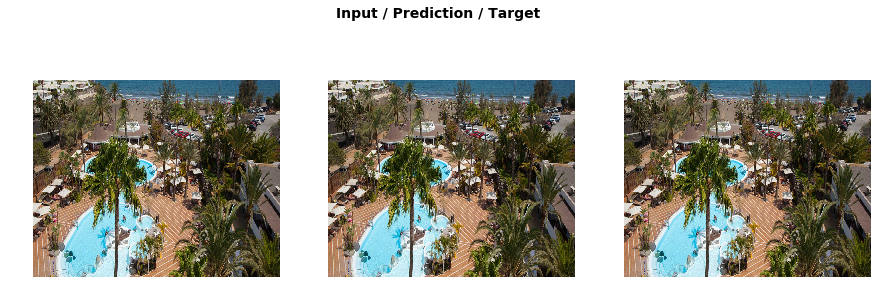

In [0]:
##fit last layers on highest res data
do_fit('4a', slice(6e-4,1e-4),cycles=4)

In [0]:
#download model
files.download('./train/low_res/models/4a.pth') 

In [0]:
learn.unfreeze()

In [0]:
torch.cuda.empty_cache()


In [0]:
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


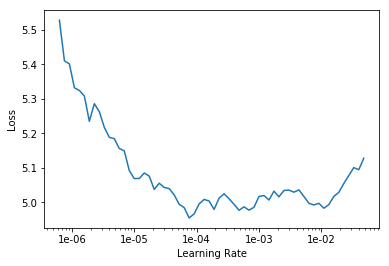

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.012326,0.014594,13:09
1,0.011933,0.014583,13:08
2,0.013097,0.014545,13:08
3,0.012067,0.014493,13:08
4,0.013262,0.014422,13:08
5,0.012133,0.014378,13:08
6,0.012839,0.014257,13:07
7,0.012540,0.014206,13:08
8,0.012812,0.014139,13:08
9,0.012932,0.014099,13:08


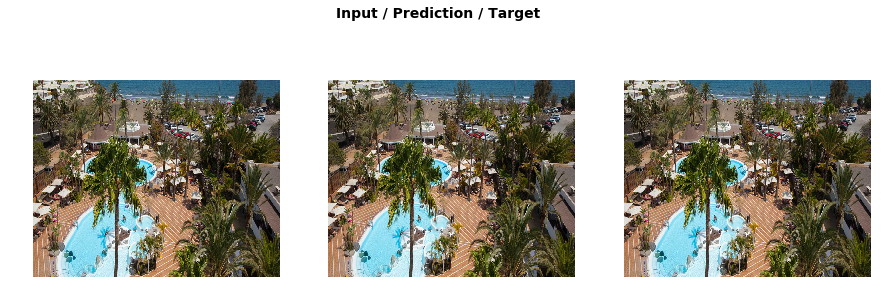

In [0]:
do_fit('4b',slice(1e-6,7e-4),cycles=6 )

In [0]:
files.download('./train/low_res/models/4b.pth') 

In [0]:
learn.freeze()

In [0]:
#run test interference with one image to see how well model is doing

In [0]:
fn = data_mr.valid_ds.x.items[0]; fn

In [0]:
img = open_image(fn); img.shape

In [0]:
p,img_hr,b = learn.predict(img)

In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [0]:
Image(img_hr).show(figsize=(18,15))